In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import os
import scipy as scp

import scienceplots

plt.style.use(['science', 'notebook', 'nature'])

In [2]:
# number of vectors taken from the computational basis
N = 20
dir_res = 'results'

# Tools


In [3]:
def n_avg(beta) :
    '''
    Returns the average number of particles at a given inverse temperature

    Parameters
    ----------
    beta : array
        inverse temperature

    Return
    ------
    n_avg : array
        average number of particles at T=1/beta

    '''
    return 1/(np.exp(beta) - 1)

n_avg(0.5)

1.5414940825367982

In [4]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : array
        matrix

    Return
    ------
    exp(M) : array
    '''
    e_val, P = np.linalg.eig(M)
    D_exp = np.diag(np.exp(e_val))
    return P @ D_exp @ np.linalg.inv(P)

In [5]:
def optimize(l, lagr_0, a, at, beta, ansatz, folder, i, **args) :
    '''
    Minimize the loss l with respect to the lagrange multipliers, 
    and write all results in folder/output.data

    Parameters
    ----------
    l : function
        loss
    lagr_0 : array
        initial guess for the lagrange multipliers
    a : array
        annihilation operator
    at : array
        creation operator
    beta : array
        inverse temperature
    ansatz : function
        compute the ansatz for the density matrix given lagrand multipliers
    folder : str
        location where output is written
    i : int
        index of optimization
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Note
    ----
    fmin[0]     # xopt 
    fmin[1]     # fopt
    fmin[2]     # nb iteration
    fmin[3]     # funcalls
    fmin[4]     # warnflag
    fmin[5]     # solution at each iterations
    '''
    sols = {}

    solution = fmin(lambda x: l(x, ansatz, a, at, beta, **args), lagr_0, retall=True, full_output=True)
    sols['inv_temp'] = np.array([beta])
    sols['history'] = np.array(solution[5])
    sols['lagr_best'] = solution[0]
    sols['rho_best'] = ansatz(sols['lagr_best'], a, at, **args)
    sols['fopt'] = np.array([solution[1]])

    subfolder = f'{folder}/output_{i}'
    os.makedirs(subfolder, exist_ok=True)

    np.savetxt(f'{subfolder}/history.txt', sols['history'])
    np.savetxt(f'{subfolder}/loss_rho_best.txt', sols['fopt'])
    np.savetxt(f'{subfolder}/lagr_best.txt', sols['lagr_best'])
    np.savetxt(f'{subfolder}/inverse_temperature.txt', sols['inv_temp'])
    np.savetxt(f'{subfolder}/rho_best.txt', sols['rho_best'])

    return sols



### $a$, $a^\dag$


In [6]:
def creation_annihilation(N) :
    '''
    Create $a$ and $a^\dag$ the single particle creation and annihilation operators
    in the matrix form, in the computational basis {|n>}.

    Parameters
    ----------
    N : int
        number of excited states to use in the basis
    
    Return
    ------
    a : array
        annihilation operator
    at : array
        creation operator
    '''
    ev_a = np.sqrt(np.arange(1, N))

    a = np.zeros((N,N))
    for i in range(0, N-1) :
        a[i,i+1] = ev_a[i]

    at = np.zeros((N,N))
    for i in range(0, N) :
        at[i,i-1] = ev_a[i-1]

    return a, at

### tests $a$ and $a^\dag$


In [7]:
a, at = creation_annihilation(N)

In [8]:
ground_state = np.zeros(N)
ground_state[0] += 1

ground_state

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [9]:
a @ ground_state

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [10]:
seven = np.zeros(N)
seven[7] += 1
seven

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [11]:
a @ seven, np.sqrt(7)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 2.64575131, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 2.6457513110645907)

In [12]:
at @ a @ seven

array([0., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [13]:
a @ at @ seven

array([0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [14]:
seven

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# Case 1


#### $\hat H = \hat a^\dag \hat a$


#### $ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


#### Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat H}}{\text{Tr}(e^{- \lambda \hat H})}$


Description of the physical system


$ \hat H = \hat a^\dag \hat a$


In [15]:
def H(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    extra_params = args 
    a, at = creation_annihilation(N)
    H = at @ a
    return H


In [16]:
H(a, at)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  

Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat H}}{\text{Tr}(e^{- \lambda \hat H})}$


In [17]:
def ansatz_1(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr * H(a, at, **args))
    rho = U / np.trace(U)
    return rho

In [18]:
ansatz_1(0.7, a, at)

array([[5.03415115e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.49988548e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.24140639e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [19]:
def lindblad(M, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M

    Parameters
    ----------
    M : array 
        density matrix
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H(a, at, **args) @ M - (H(a, at, **args).T @ M.T).T)
    L1 = (n_avg(beta) + 1) * (a @ (a @ M.T).T - 0.5 * (at @ a @ M + (at @ a @ M.T).T))
    L2 = n_avg(beta) * (at @ (at @ M.T).T - 0.5 * (a @ at @ M + (a @ at @ M.T).T))
    return L0 + L1 + L2

In [20]:
lindblad(ansatz_1(0.5, a, at), a, at, 0.5)

array([[ 8.62637829e-04+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -1.94289029e-16+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0

Loss


In [21]:
def loss(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')

In [22]:
loss(np.array([0.5]), ansatz_1, a, at, 0.5)

0.0008626378291870958

##### Parameters


In [23]:
case = 1
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [24]:
N = 20
a, at = creation_annihilation(N)
betas = np.linspace(0.3, 5, 10)        # true inverse temperature
lambda_0 = 1

##### compute


In [25]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, ansatz_1, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.047213
         Iterations: 16
         Function evaluations: 32
[0.3]
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 13
         Function evaluations: 26
[0.82226562]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 14
         Function evaluations: 28
[1.34443359]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 16
         Function evaluations: 32
[1.86669922]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 18
         Function evaluations: 36
[2.38886719]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 19
         Function evaluations: 38
[2.91113281]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 

##### plot


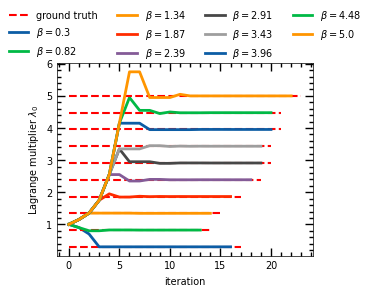

In [26]:
lagr_to_plot = [0]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions, lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


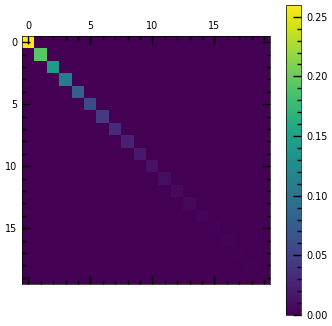

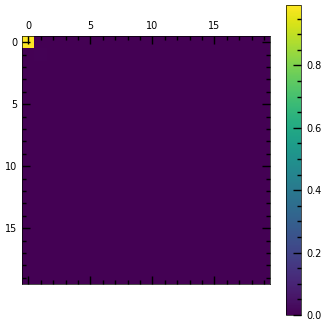

In [27]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 2


#### $\hat H = \hat a^\dag \hat a$


#### $ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


#### Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


Description of the physical system


$ \hat H = \hat a^\dag \hat a$


In [28]:
def H(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    extra_params = args 
    a, at = creation_annihilation(N)
    H = at @ a
    return H


In [29]:
H(a, at)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  

Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


In [30]:
def ansatz_2(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * H(a, at, **args) - lagr[1] * at @ at @ a @ a)
    rho = U / np.trace(U)
    return rho

In [31]:
ansatz_2(np.array([0.7, 1]), a, at)

array([[6.53482660e-001, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 3.24509885e-001, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 2.18088532e-002,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [32]:
def lindblad(M, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M

    Parameters
    ----------
    M : array 
        density matrix
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H(a, at, **args) @ M - (H(a, at, **args).T @ M.T).T)
    L1 = (n_avg(beta) + 1) * (a @ (a @ M.T).T - 0.5 * (at @ a @ M + (at @ a @ M.T).T))
    L2 = n_avg(beta) * (at @ (at @ M.T).T - 0.5 * (a @ at @ M + (a @ at @ M.T).T))
    return L0 + L1 + L2

In [33]:
lindblad(ansatz_2([0.5, 1], a, at), a, at, 0.5)

array([[ 0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j],
       [ 0.00000000e+000+0.j, -9.75850949e-001+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j],
      

Loss


In [34]:
def loss(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')

In [35]:
loss([0.5, 1], ansatz_2, a, at, beta)

0.728931731894231

##### Parameters


In [36]:
case = 2
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [37]:
N = 20
a, at = creation_annihilation(N)
betas = np.linspace(0.3, 5, 10)        # true inverse temperature
lambda_0 = np.array([1, 1])

In [38]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, ansatz_2, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.047238
         Iterations: 70
         Function evaluations: 132
[3.00161183e-01 1.07100093e-05]
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 53
         Function evaluations: 102
[ 8.22258150e-01 -8.37378085e-06]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 46
         Function evaluations: 87
[ 1.34440958e+00 -1.31928690e-06]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 37
         Function evaluations: 73
[ 1.86666956e+00 -3.41103197e-05]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 41
         Function evaluations: 81
[2.38888572e+00 3.16680668e-05]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 49
         Function evaluations: 97
[ 2.

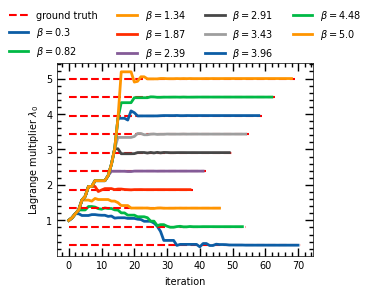

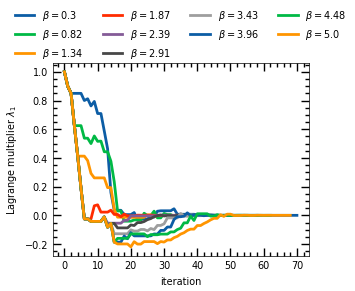

In [39]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


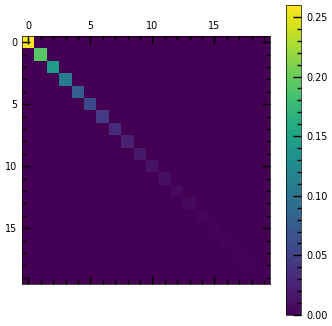

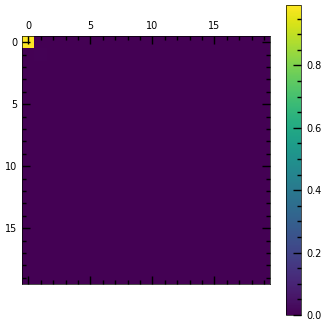

In [40]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 3 : add drive


#### $\hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right)$


#### $ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


#### Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


Description of the physical system


$ \hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right) $


In [41]:
def H(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    epsilon = args['epsilon']
    a, at = creation_annihilation(N)
    H = at @ a + epsilon * (a + at)
    return H


In [42]:
H(a, at, **{'epsilon' : 0.2})

array([[ 0.        ,  0.2       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.87177979],
       [ 0.2       ,  1.        ,  0.28284271,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.28284271,  2.        ,  0.34641016,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.34641016,  3.        ,  0.4       ,
         0.        ,  0.        ,  0.        ,  

Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


In [43]:
def ansatz_3(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * H(a, at, **args) - lagr[1] * at @ at @ a @ a)
    rho = U / np.trace(U)
    return rho

In [44]:
ansatz_3(np.array([0.7, 1]), a, at, **{'epsilon' : 0.2})

array([[ 6.49578903e-01, -6.53065687e-02,  2.89363510e-03,
        -7.46358709e-05,  1.28534552e-06, -1.60488469e-08,
         1.53486282e-10, -1.16922313e-12,  7.30529907e-15,
        -3.82950310e-17,  1.71499446e-19, -6.69351337e-22,
         8.43316792e-22, -2.33950640e-19,  7.37412918e-17,
        -2.60863473e-14,  1.02720753e-11, -4.47040617e-09,
         2.13681758e-06, -1.11564442e-03],
       [-6.53065687e-02,  3.27138277e-01, -2.22127131e-02,
         6.96275451e-04, -1.34282446e-05,  1.80582334e-07,
        -1.82007318e-09,  1.44174482e-11, -9.28456996e-14,
         4.98575756e-16, -2.27712467e-18,  8.98741980e-21,
        -1.13461718e-22,  2.30420158e-20, -7.29432892e-18,
         2.58995875e-15, -1.02311363e-12,  4.46500349e-10,
        -2.13947056e-07,  1.11945916e-04],
       [ 2.89363510e-03, -2.22127131e-02,  2.30288407e-02,
        -1.14737786e-03,  2.77562640e-05, -4.28332980e-07,
         4.73883221e-09, -4.01611774e-11,  2.72245114e-13,
        -1.52210780e-15,  7.1

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [45]:
def lindblad(M, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M

    Parameters
    ----------
    M : array 
        density matrix
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H(a, at, **args) @ M - (H(a, at, **args).T @ M.T).T)
    L1 = (n_avg(beta) + 1) * (a @ (a @ M.T).T - 0.5 * (at @ a @ M + (at @ a @ M.T).T))
    L2 = n_avg(beta) * (at @ (at @ M.T).T - 0.5 * (a @ at @ M + (a @ at @ M.T).T))
    return L0 + L1 + L2

In [46]:
lindblad(ansatz_3([0.5, 1], a, at, **{'epsilon' : 0.2}), a, at, 0.5, **{'epsilon' : 0.2})

array([[ 6.25115057e-03-2.77555756e-17j,  1.01163789e-01-8.32667268e-17j,
        -7.02204462e-03-6.39175726e-03j,  2.04832000e-04+3.71519227e-04j,
        -3.48993119e-06-9.51993814e-06j,  4.00792207e-08+1.46411563e-07j,
        -3.36730089e-10-1.54478305e-09j,  2.18335062e-12+1.20729664e-11j,
        -1.13460921e-14-7.34928881e-14j,  4.86040816e-17+3.61120832e-16j,
        -1.75415907e-19-1.47104873e-18j,  5.07409182e-22+5.11082548e-21j,
         1.43183140e-20-1.55468905e-20j, -6.54734880e-18+7.02589702e-18j,
         3.34736600e-15-3.56004860e-15j, -1.89921831e-12+2.00463712e-12j,
         1.18797071e-09-1.24577863e-09j, -8.14432289e-07+8.49254969e-07j,
         6.08783650e-04-6.31681640e-04j,  1.85844773e-02+5.10207211e-01j],
       [ 9.61518113e-02-5.55111512e-17j, -9.82026005e-01+5.55111512e-17j,
         3.53512010e-02+7.60069121e-02j,  8.15165633e-05-5.35812290e-03j,
        -2.22163620e-05+1.53482000e-04j,  5.08955393e-07-2.53863571e-06j,
        -6.49443644e-09+2.81948402e-0

Loss


In [47]:
def loss(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')

In [48]:
loss([0.5, 1], ansatz_3, a, at, beta, **{'epsilon' : 0.2})

0.9986472921157399

##### Parameters


In [49]:
case = 3
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [50]:
N = 20
a, at = creation_annihilation(N)
betas = np.linspace(0.3, 5, 10)        # true inverse temperature
lambda_0 = np.array([1, 0.05])
params_H = {
    'epsilon' : 0.2
}

In [51]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, ansatz_3, folder, i, **params_H)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.459469
         Iterations: 56
         Function evaluations: 107
[0.18792217 0.00817617]
Optimization terminated successfully.
         Current function value: 0.409335
         Iterations: 35
         Function evaluations: 66
[0.67912527 0.02505494]
Optimization terminated successfully.
         Current function value: 0.413328
         Iterations: 32
         Function evaluations: 61
[1.16700994 0.02532878]
Optimization terminated successfully.
         Current function value: 0.440992
         Iterations: 35
         Function evaluations: 69
[1.61580168 0.02898956]
Optimization terminated successfully.
         Current function value: 0.458834
         Iterations: 43
         Function evaluations: 81
[2.00155006 0.03231325]
Optimization terminated successfully.
         Current function value: 0.469682
         Iterations: 39
         Function evaluations: 75
[2.31645526 0.03516306]
Optimization terminated suc

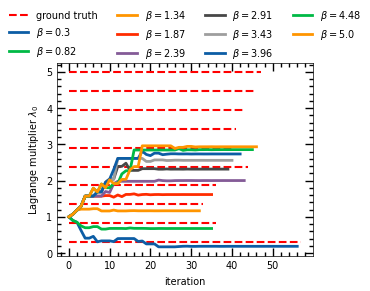

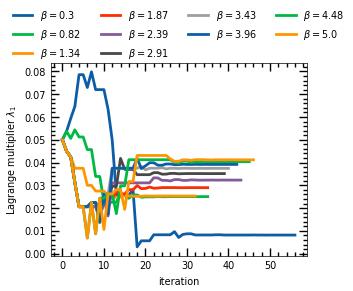

In [52]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


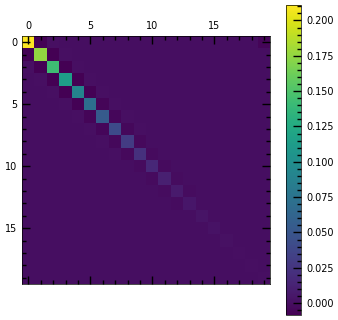

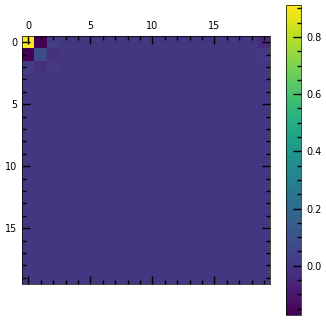

In [53]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 4 : add Kerr term


#### $\hat H = \hat a^\dag \hat a + \epsilon \, \hat a^\dag \hat a^\dag \hat a \hat a $


#### $ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


#### Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


Description of the physical system


$ \hat H = \hat a^\dag \hat a + \epsilon \, \hat a^\dag \hat a^\dag \hat a \hat a $


In [54]:
def H(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    epsilon = args['epsilon']
    a, at = creation_annihilation(N)
    H = at @ a + epsilon * (at @ at @ a @ a)
    return H


In [55]:
H(a, at, **{'epsilon' : 0.2})

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  2.4,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  4.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  6.4,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  9. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , 12. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.

Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


In [56]:
def ansatz_4(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * H(a, at, **args) - lagr[1] * at @ at @ a @ a)
    rho = U / np.trace(U)
    return rho

In [57]:
ansatz_4(np.array([0.7, 1]), a, at, **{'epsilon' : 0.2})

array([[6.57056389e-001, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 3.26284547e-001, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.65729168e-002,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [58]:
def lindblad(M, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M

    Parameters
    ----------
    M : array 
        density matrix
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H(a, at, **args) @ M - (H(a, at, **args).T @ M.T).T)
    L1 = (n_avg(beta) + 1) * (a @ (a @ M.T).T - 0.5 * (at @ a @ M + (at @ a @ M.T).T))
    L2 = n_avg(beta) * (at @ (at @ M.T).T - 0.5 * (a @ at @ M + (a @ at @ M.T).T))
    return L0 + L1 + L2

In [59]:
lindblad(ansatz_4([0.5, 1], a, at, **{'epsilon' : 0.2}), a, at, 0.5, **{'epsilon' : 0.2})

array([[ 0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j],
       [ 0.00000000e+000+0.j, -1.00918695e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
         0.00000000e+000+0.j,  0.00000000e+000+0.j],
      

Loss


In [29]:
def loss(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')

In [61]:
loss([0.5, 1], ansatz_4, a, at, beta, **{'epsilon' : 0.2})

0.7330298056841565

##### Parameters


In [62]:
case = 4
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [63]:
N = 20
a, at = creation_annihilation(N)
betas = np.linspace(0.3, 5, 10)        # true inverse temperature
lambda_0 = np.array([1, 0.05])
params_H = {
    'epsilon' : 0.1
}

In [64]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, ansatz_4, folder, i, **params_H)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.047220
         Iterations: 57
         Function evaluations: 109
[ 0.30005542 -0.03000316]
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 42
         Function evaluations: 79
[ 0.82221058 -0.08221503]
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 44
         Function evaluations: 86
[ 1.34443344 -0.13442096]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 49
         Function evaluations: 95
[ 1.86664031 -0.18667871]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 82
         Function evaluations: 161
[ 2.38888453 -0.23885032]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 53
         Function evaluations: 105
[ 2.91109813 -0.29113933]
Optimization 

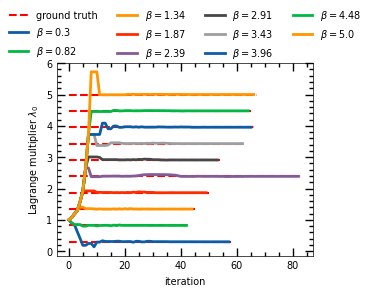

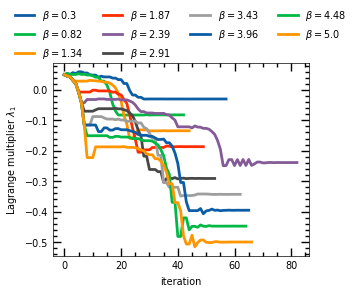

In [65]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


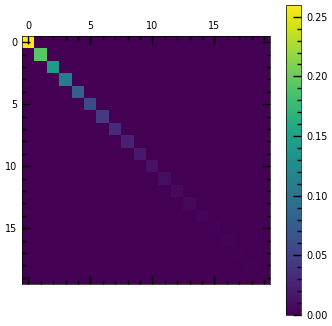

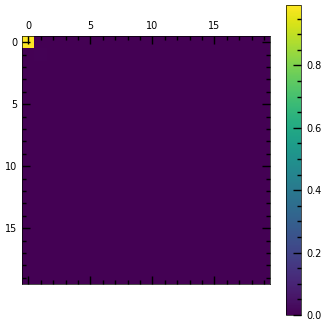

In [66]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Compare cases


##### compute


In [67]:
cases_to_compare = np.array([1, 2, 3, 4])
is_to_plot = np.arange(10)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        filename = f'results/case_{c}/output_{i}/loss_rho_best.txt'
        loss_best = np.loadtxt(filename)
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_loss.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


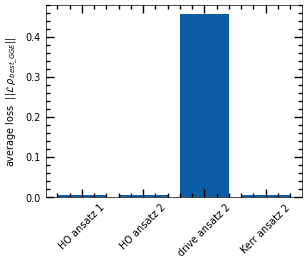

In [68]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_loss.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['HO ansatz 1', 'HO ansatz 2', 'drive ansatz 2', 'Kerr ansatz 2']

plt.bar(X, losses)
plt.ylabel(r'average loss  $||  \mathcal{L} \, \rho_{\,best\_GGE}||$')
plt.xticks(range(len(cases_to_compare)), X, rotation=45)
plt.savefig('figs/comp_avg_loss.pdf')


Outline :

- check that observables are well reproduced
- Use better guess that generalizes the conserved quantities
- reproduce Wouters work (test other Hamiltonians) for 1 particle
- extend the code to multi-body systems (define $\hat a_j$ ? tensor products of $\hat a_j$'s ?)
- extend the code to open multi-body systems (Lagrange multipliers vary with time)


# Entropy production with drive


#### $\hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right)$


#### $ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


#### Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


Description of the physical system


$ \hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right) $


In [15]:
def H(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    epsilon = args['epsilon']
    a, at = creation_annihilation(N)
    H = at @ a + epsilon * (a + at)
    return H


In [16]:
H(a, at, **{'epsilon' : 0.2})

array([[ 0.        ,  0.2       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.87177979],
       [ 0.2       ,  1.        ,  0.28284271,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.28284271,  2.        ,  0.34641016,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.34641016,  3.        ,  0.4       ,
         0.        ,  0.        ,  0.        ,  

Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat H - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$


In [17]:
def ansatz_3(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * H(a, at, **args) - lagr[1] * at @ at @ a @ a)
    rho = U / np.trace(U)
    return rho

In [18]:
ansatz_3(np.array([0.7, 1]), a, at, **{'epsilon' : 0.2})

array([[ 6.49578903e-01, -6.53065687e-02,  2.89363510e-03,
        -7.46358709e-05,  1.28534552e-06, -1.60488469e-08,
         1.53486282e-10, -1.16922313e-12,  7.30529907e-15,
        -3.82950310e-17,  1.71499446e-19, -6.69351337e-22,
         8.43316792e-22, -2.33950640e-19,  7.37412918e-17,
        -2.60863473e-14,  1.02720753e-11, -4.47040617e-09,
         2.13681758e-06, -1.11564442e-03],
       [-6.53065687e-02,  3.27138277e-01, -2.22127131e-02,
         6.96275451e-04, -1.34282446e-05,  1.80582334e-07,
        -1.82007318e-09,  1.44174482e-11, -9.28456996e-14,
         4.98575756e-16, -2.27712467e-18,  8.98741980e-21,
        -1.13461718e-22,  2.30420158e-20, -7.29432892e-18,
         2.58995875e-15, -1.02311363e-12,  4.46500349e-10,
        -2.13947056e-07,  1.11945916e-04],
       [ 2.89363510e-03, -2.22127131e-02,  2.30288407e-02,
        -1.14737786e-03,  2.77562640e-05, -4.28332980e-07,
         4.73883221e-09, -4.01611774e-11,  2.72245114e-13,
        -1.52210780e-15,  7.1

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [19]:
def lindblad(M, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M

    Parameters
    ----------
    M : array 
        density matrix
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H(a, at, **args) @ M - (H(a, at, **args).T @ M.T).T)
    L1 = (n_avg(beta) + 1) * (a @ (a @ M.T).T - 0.5 * (at @ a @ M + (at @ a @ M.T).T))
    L2 = n_avg(beta) * (at @ (at @ M.T).T - 0.5 * (a @ at @ M + (a @ at @ M.T).T))
    return L0 + L1 + L2

In [20]:
lindblad(ansatz_3([0.5, 1], a, at, **{'epsilon' : 0.2}), a, at, 0.5, **{'epsilon' : 0.2})

array([[ 6.25115057e-03-2.77555756e-17j,  1.01163789e-01-8.32667268e-17j,
        -7.02204462e-03-6.39175726e-03j,  2.04832000e-04+3.71519227e-04j,
        -3.48993119e-06-9.51993814e-06j,  4.00792207e-08+1.46411563e-07j,
        -3.36730089e-10-1.54478305e-09j,  2.18335062e-12+1.20729664e-11j,
        -1.13460921e-14-7.34928881e-14j,  4.86040816e-17+3.61120832e-16j,
        -1.75415907e-19-1.47104873e-18j,  5.07409182e-22+5.11082548e-21j,
         1.43183140e-20-1.55468905e-20j, -6.54734880e-18+7.02589702e-18j,
         3.34736600e-15-3.56004860e-15j, -1.89921831e-12+2.00463712e-12j,
         1.18797071e-09-1.24577863e-09j, -8.14432289e-07+8.49254969e-07j,
         6.08783650e-04-6.31681640e-04j,  1.85844773e-02+5.10207211e-01j],
       [ 9.61518113e-02-5.55111512e-17j, -9.82026005e-01+5.55111512e-17j,
         3.53512010e-02+7.60069121e-02j,  8.15165633e-05-5.35812290e-03j,
        -2.22163620e-05+1.53482000e-04j,  5.08955393e-07-2.53863571e-06j,
        -6.49443644e-09+2.81948402e-0

Loss


In [32]:
def loss_lindblad(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')
    # rho_ansatz = ansatz(lagr, a, at, **args)
    # return np.abs(np.trace((np.identity(rho_ansatz.shape[0]) + scp.linalg.logm(rho_ansatz)) * lindblad(rho_ansatz, a, at, beta, **args)))

In [ ]:
def loss(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    # return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')
    rho_ansatz = ansatz(lagr, a, at, **args)
    return np.abs(np.trace((np.identity(rho_ansatz.shape[0]) + scp.linalg.logm(rho_ansatz)) * lindblad(rho_ansatz, a, at, beta, **args)))

In [30]:
beta = 1
loss([0.5, 1], ansatz_3, a, at, beta, **{'epsilon' : 0.2})

1.5304144213143709

##### Parameters


In [33]:
case = 5
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [34]:
N = 25
a, at = creation_annihilation(N)
betas = np.linspace(0.3, 5, 10)        # true inverse temperature
lambda_0 = np.array([1, 0.05])
params_H = {
    'epsilon' : 0.2
}

In [37]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, ansatz_3, folder, i, **params_H)
    print(opt['lagr_best'])
    np.savetxt(f'{folder}/loss_rho_best.txt', np.array([loss_lindblad(opt['lagr_best'], ansatz_3, a, at, beta, **params_H)]))

Optimization terminated successfully.
         Current function value: 0.461562
         Iterations: 57
         Function evaluations: 106
[0.18433945 0.00841683]
Optimization terminated successfully.
         Current function value: 0.437407
         Iterations: 36
         Function evaluations: 69
[0.67577366 0.0220148 ]
Optimization terminated successfully.
         Current function value: 0.451818
         Iterations: 36
         Function evaluations: 71
[1.14622081 0.0202978 ]
Optimization terminated successfully.
         Current function value: 0.482508
         Iterations: 34
         Function evaluations: 65
[1.57970255 0.02253253]
Optimization terminated successfully.
         Current function value: 0.501368
         Iterations: 40
         Function evaluations: 77
[1.94649845 0.02476172]
Optimization terminated successfully.
         Current function value: 0.512622
         Iterations: 46
         Function evaluations: 89
[2.24076212 0.02670066]
Optimization terminated suc

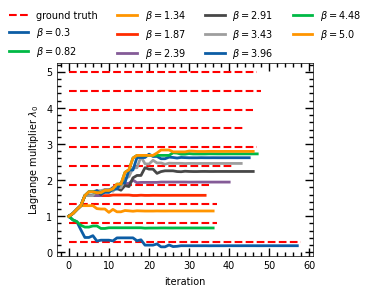

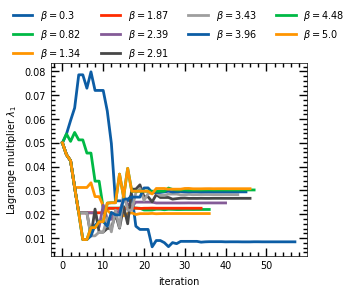

In [38]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


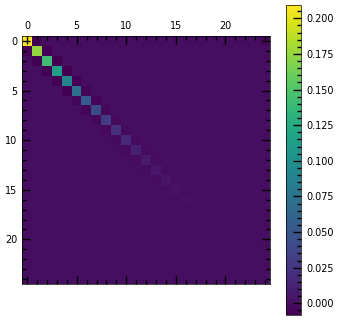

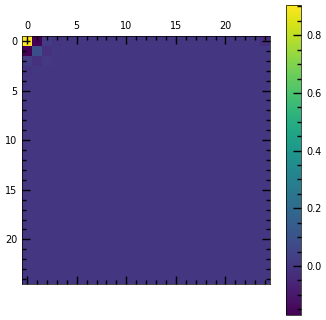

In [39]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Compare cases


##### compute


In [40]:
cases_to_compare = np.array([1, 2, 3, 4, 5])
is_to_plot = np.arange(10)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        filename = f'results/case_{c}/output_{i}/loss_rho_best.txt'
        loss_best = np.loadtxt(filename)
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_loss.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


([<matplotlib.axis.XTick at 0x1f94a023250>,
 [Text(0, 0, 'HO ansatz 1'),
  Text(1, 0, 'HO ansatz 2'),
  Text(2, 0, 'drive ansatz 2'),
  Text(3, 0, 'Kerr ansatz 2'),
  Text(4, 0, 'entropy production')])

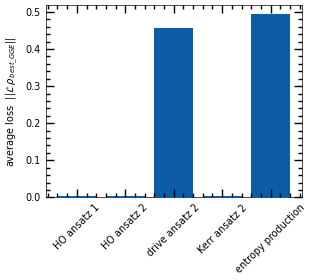

In [42]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_loss.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['HO ansatz 1', 'HO ansatz 2', 'drive ansatz 2', 'Kerr ansatz 2', 'S-prod, ansatz 3']

plt.bar(X, losses)
plt.ylabel(r'average loss  $||  \mathcal{L} \, \rho_{\,best\_GGE}||$')
plt.xticks(range(len(cases_to_compare)), X, rotation=45)
# plt.savefig('figs/comp_avg_loss.pdf')


# Entropy production with drive - ansatz drive


#### $\hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right)$


#### $ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


#### Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat a^\dagger \hat a - \lambda_1 \left( \hat a + \hat a^\dag \right) }}{\text{Tr}(e^{- \lambda_0 \hat a^\dagger \hat a - \lambda_1 \left( \hat a + \hat a^\dag \right) })}$


Description of the physical system


$ \hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right) $


In [ ]:
def H(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    epsilon = args['epsilon']
    a, at = creation_annihilation(N)
    H = at @ a + epsilon * (a + at)
    return H


In [ ]:
H(a, at, **{'epsilon' : 0.2})

array([[ 0.        ,  0.2       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.87177979],
       [ 0.2       ,  1.        ,  0.28284271,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.28284271,  2.        ,  0.34641016,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.34641016,  3.        ,  0.4       ,
         0.        ,  0.        ,  0.        ,  

Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat a^\dagger \hat a - \lambda_1 \left( \hat a + \hat a^\dag \right) }}{\text{Tr}(e^{- \lambda_0 \hat a^\dagger \hat a - \lambda_1 \left( \hat a + \hat a^\dag \right) })}$


In [43]:
def ansatz_4(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * at @ a - lagr[1] * (a + at))
    rho = U / np.trace(U)
    return rho

In [44]:
ansatz_4(np.array([0.7, 1]), a, at, **{'epsilon' : 0.2})

array([[ 1.80203785e-01, -1.29596048e-01,  6.59029127e-02,
        -2.73635117e-02,  9.83942423e-03, -3.16455416e-03,
         9.29104897e-04, -2.52547690e-04,  6.42129617e-05,
        -1.53907979e-05,  3.49002844e-06, -7.17646428e-07,
         9.44609013e-09,  4.61550835e-07, -1.53316235e-06,
         4.55112444e-06, -1.29027664e-05,  3.55372852e-05,
        -9.65698834e-05,  2.62878055e-04, -7.26237135e-04,
         2.05492320e-03, -5.98435239e-03,  1.79619830e-02,
        -5.55303792e-02],
       [-1.29596048e-01,  1.82687344e-01, -1.38407403e-01,
         7.63626670e-02, -3.42527938e-02,  1.32015148e-02,
        -4.51748099e-03,  1.40231957e-03, -4.00897348e-04,
         1.06732540e-04, -2.66891728e-05,  6.30619753e-06,
        -1.39712414e-06,  2.20475452e-07,  2.42700234e-07,
        -1.04336210e-06,  3.50919053e-06, -1.13447395e-05,
         3.59536955e-05, -1.12829608e-04,  3.53648553e-04,
        -1.11500124e-03,  3.55513047e-03, -1.15051364e-02,
         3.78744051e-02],
    

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [45]:
def lindblad(M, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M

    Parameters
    ----------
    M : array 
        density matrix
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H(a, at, **args) @ M - (H(a, at, **args).T @ M.T).T)
    L1 = (n_avg(beta) + 1) * (a @ (a @ M.T).T - 0.5 * (at @ a @ M + (at @ a @ M.T).T))
    L2 = n_avg(beta) * (at @ (at @ M.T).T - 0.5 * (a @ at @ M + (a @ at @ M.T).T))
    return L0 + L1 + L2

In [46]:
lindblad(ansatz_4([0.5, 1], a, at, **{'epsilon' : 0.2}), a, at, 0.5, **{'epsilon' : 0.2})

array([[ 1.36924005e-01+3.81639165e-17j, -6.91579178e-02-5.79601808e-02j,
         2.05651656e-02+6.45038479e-02j, -1.20283140e-03-4.39599457e-02j,
        -2.72985065e-03+2.30625211e-02j,  2.08799120e-03-1.01454819e-02j,
        -1.03295682e-03+3.91128197e-03j,  4.14952451e-04-1.35723919e-03j,
        -1.45401128e-04+4.31535754e-04j,  4.58875919e-05-1.27196010e-04j,
        -1.27540375e-05+3.44215766e-05j,  4.69418173e-07-5.64611354e-06j,
         1.30110573e-05-1.20676862e-05j, -5.51808609e-05+5.22011166e-05j,
         1.99898595e-04-1.76651263e-04j, -6.57467449e-04+5.42108559e-04j,
         1.97621703e-03-1.52742483e-03j, -5.44937465e-03+3.97333803e-03j,
         1.38479829e-02-9.60682208e-03j, -3.26304975e-02+2.17853807e-02j,
         7.19074567e-02-4.69027725e-02j, -1.49951336e-01+9.73792244e-02j,
         3.00516083e-01-1.98599111e-01j, -5.89700187e-01+4.05550706e-01j,
         1.20544348e+00-8.43074865e-01j],
       [-3.63912031e-01+5.79601808e-02j,  1.07204929e-01-6.93889390e-1

Loss


In [47]:
def loss_lindblad(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')
    # rho_ansatz = ansatz(lagr, a, at, **args)
    # return np.abs(np.trace((np.identity(rho_ansatz.shape[0]) + scp.linalg.logm(rho_ansatz)) * lindblad(rho_ansatz, a, at, beta, **args)))

In [48]:
def loss(lagr, ansatz, a, at, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    a : array
        annihilation operator
    at : array
        creation operator
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    # return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), a, at, beta, **args), 'nuc')
    rho_ansatz = ansatz(lagr, a, at, **args)
    return np.abs(np.trace((np.identity(rho_ansatz.shape[0]) + scp.linalg.logm(rho_ansatz)) * lindblad(rho_ansatz, a, at, beta, **args)))

In [49]:
beta = 1
loss([0.5, 1], ansatz_4, a, at, beta, **{'epsilon' : 0.2})

2.4384856828781127

##### Parameters


In [50]:
case = 6
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [ ]:
N = 20
a, at = creation_annihilation(N)
betas = np.linspace(0.3, 5, 10)        # true inverse temperature
lambda_0 = np.array([1, 0.05])
params_H = {
    'epsilon' : 0.2
}

In [52]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, ansatz_4, folder, i, **params_H)
    print(opt['lagr_best'])
    np.savetxt(f'{folder}/loss_rho_best.txt', np.array([loss_lindblad(opt['lagr_best'], ansatz_4, a, at, beta, **params_H)]))

Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 29
         Function evaluations: 58
[0.30495803 0.08059219]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 62
[0.82602705 0.06010983]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 31
         Function evaluations: 56
[1.34560596 0.03167518]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 27
         Function evaluations: 53
[ 1.86669461 -0.00339517]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 44
         Function evaluations: 79
[ 2.39049967 -0.03197915]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 42
         Function evaluations: 77
[ 2.91949568 -0.06579546]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 72
[ 3.45474956 -0.09333249]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 40
         Function evaluations: 74
[ 4.013079   -0.13378432]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 51
         Function evaluations: 97
[ 4.58746147 -0.15929739]
logm result may be inaccurate, approximate err = 1.3330113079178482e-11
logm result may be inaccurate, approximate err = 2.6288513658894837e-12
Optimization terminated successfully

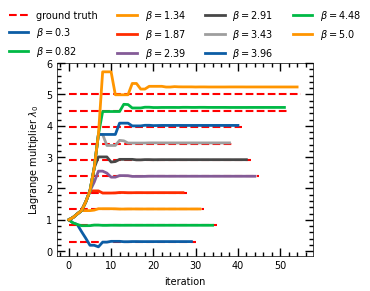

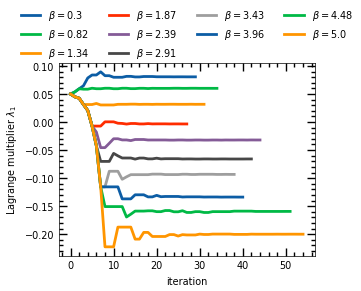

In [53]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


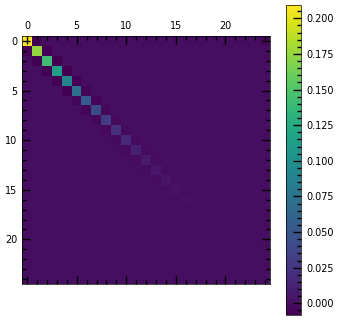

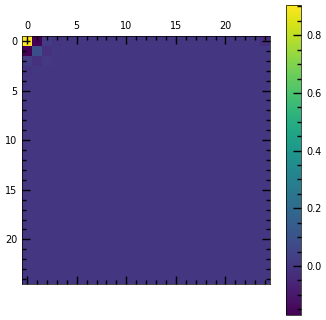

In [ ]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Compare cases


##### compute


In [64]:
cases_to_compare = np.array([2, 3, 4, 5, 6])
is_to_plot = np.arange(10)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        if i != 6 :
            filename = f'results/case_{c}/output_{i}/loss_rho_best.txt'
            loss_best = np.loadtxt(filename)
        else :
            filename = f'results/case_{c}/output_{i}/lagr_best.txt'
            param_best = np.loadtxt(filename, unpack=True)
            loss_best = loss_lindblad(param_best, ansatz_4, a, at, beta, **{'epsilon' : 0.2})
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_loss.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


([<matplotlib.axis.XTick at 0x1f94a565810>,
 [Text(0, 0, 'HO ansatz 2'),
  Text(1, 0, 'drive ansatz 2'),
  Text(2, 0, 'Kerr ansatz 2'),
  Text(3, 0, 'S-prod, ansatz 3'),
  Text(4, 0, 'S-prod, ansatz 4')])

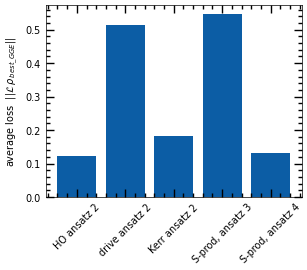

In [65]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_loss.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['HO ansatz 2', 'drive ansatz 2', 'Kerr ansatz 2', 'S-prod, ansatz 3','S-prod, ansatz 4' ]

plt.bar(X, losses)
plt.ylabel(r'average loss  $||  \mathcal{L} \, \rho_{\,best\_GGE}||$')
plt.xticks(range(len(cases_to_compare)), X, rotation=45)
# plt.savefig('figs/comp_avg_loss.pdf')


In [ ]:
filename = f'results/case_{c}/output_{i}/loss_rho_best.txt'
loss_best = np.loadtxt(filename)
loss_lindblad([0.5, 1], ansatz_4, a, at, beta, **{'epsilon' : 0.2})